In [38]:
import os
import functools
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import lmfit
import corner

from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
siv_path = "../data/2021_03_03_stitched/"
prefix = "sweeper_fwd_avg_"
siv_files = []
for file in os.listdir(siv_path):
    if file.startswith(prefix) and file.endswith(".txt"):
        siv_files.append(file[len(prefix):])
        
print(siv_files)

['10_17_58.txt', '10_47_04.txt', '11_06_07.txt', '11_14_47.txt', '11_22_49.txt', '11_28_41.txt']


# Plot SiV Data

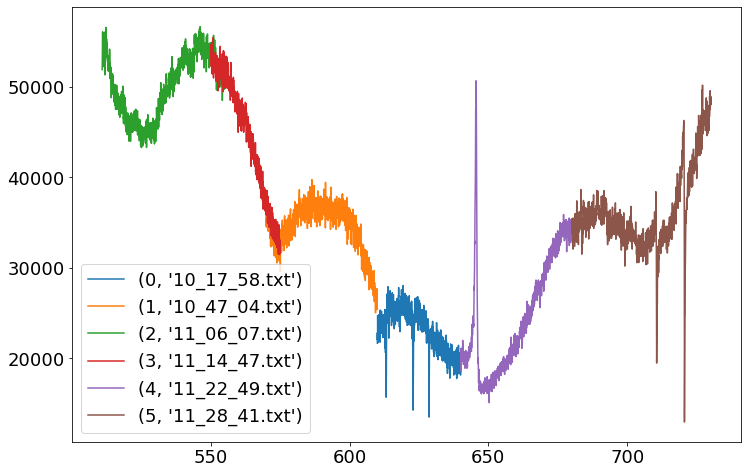

In [3]:
cavity_freqs = []
cavity_intensity = []

color = plt.cm.jet(np.linspace(0, 1, len(siv_files)))
plt.figure(figsize=[12, 8])

for i, file in enumerate(siv_files):
    freqs, intensity = np.loadtxt(siv_path + prefix + file)
    freqs = 1000 * (freqs - 406) # Re-center, convert to GHz
    plt.plot(freqs, intensity, label=(i, file))
    
    cavity_freqs.extend(freqs)
    cavity_intensity.extend(intensity)
plt.legend()

# Sort by frequency values
cavity_freqs, cavity_intensity = zip(*sorted(zip(cavity_freqs, cavity_intensity)))
cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Plot Filter ranges to remove SiV peaks

In [4]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(612, 615), (621.5, 624.5), (627.5, 629.5), (643, 647.5), (709, 712), (718.5, 722.5)]

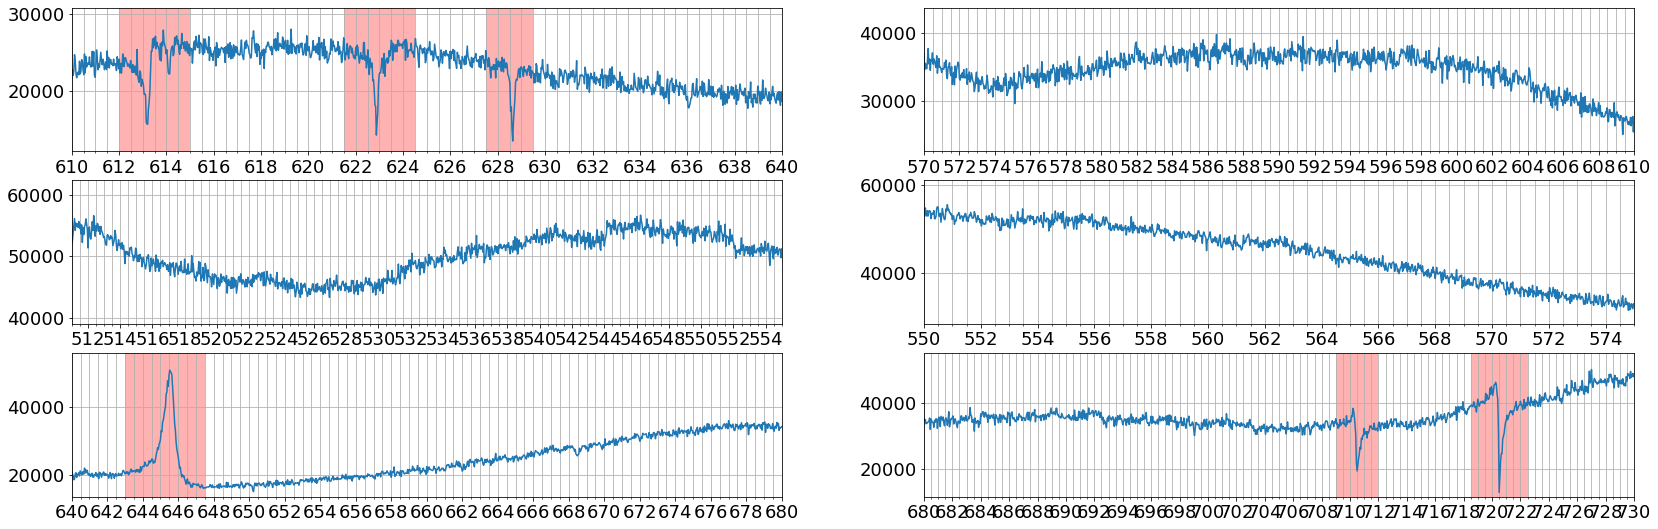

In [5]:
fig, ax = plt.subplots(figsize=[28, 9], nrows=3, ncols=2)
for i, file in enumerate(siv_files):
    axes = ax[i//2, i%2]    
    freqs, intensity = np.loadtxt(siv_path + prefix + file)
    freqs = 1000 * (freqs - 406) # Re-center, convert to GHz
    axes.plot(freqs, intensity)
    
    for start, end in filter_range:
        axes.add_patch(patches.Rectangle((start, 0), (end-start), 70000, facecolor='red', alpha=0.3))
        
    axes.set_xlim([min(freqs), max(freqs)])
    axes.set_ylim([0.9 * min(intensity), 1.1 * max(intensity)])
    
    axes.xaxis.set_major_locator(MultipleLocator(2))
    axes.xaxis.set_minor_locator(MultipleLocator(0.5))
    axes.grid(which='both')

## Filtering out SiV Peaks

In [6]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

def in_range(arr, ranges):
    """ Returns indices of `arr` that lie in any of the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # OR of (x >= start AND x <= end) leads to all x that are 
    # inside of any (start, end) range.
    for start, end in ranges:
        conditions.append((arr >= start) & (arr <= end)) 
    return np.where(functools.reduce(np.logical_or, conditions))

Text(0.5, 1.0, 'Filtered cavity spectrum')

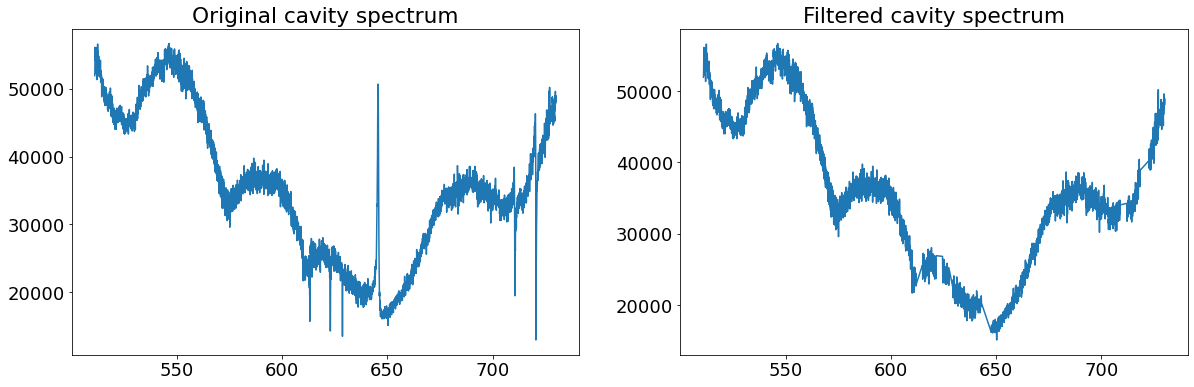

In [7]:
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

fig, ax = plt.subplots(figsize=[20, 6], ncols=2)
ax[0].plot(cavity_freqs, cavity_intensity)
ax[0].set_title("Original cavity spectrum")
ax[1].plot(cavity_freqs_filtered, cavity_intensity_filtered)
ax[1].set_title("Filtered cavity spectrum")

# ----------------------------------------------------------
# Fit Cavity Spectrum

## Fit cavity function to filtered cavity scan

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 5487
    # variables        = 4
    chi-square         = 9.3645e+10
    reduced chi-square = 17079133.3
    Akaike info crit   = 91381.0288
    Bayesian info crit = 91407.4693
[[Variables]]
    w_c:    642.845773 +/- 0.21788100 (0.03%) (init = 650)
    k_in:   53.4549408 +/- 0.73387416 (1.37%) (init = 100)
    k_tot:  67.5904494 +/- 0.94610249 (1.40%) (init = 100)
    A:      60381.5756 +/- 398.479500 (0.66%) (init = 40000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.996
    C(k_tot, A)    =  0.922
    C(k_in, A)     =  0.889
    C(w_c, A)      = -0.129


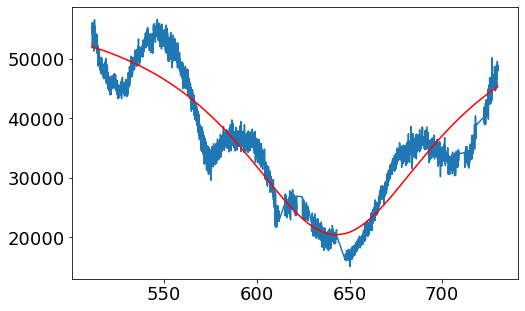

In [8]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=650, min=640, max=660),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=100, min=0, max=1000),
    Parameter('A', value=40000, min=0, max=70000),
    Parameter('B', value=0, vary=False),
)

results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered)
lmfit.report_fit(results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs_filtered, cavity_ref_model.eval(params=results.params, w=cavity_freqs_filtered), 'r')

fit_ratio = cavity_intensity_filtered / cavity_ref_model.eval(params=results.params, w=cavity_freqs_filtered)

### Fit sinusoidal to fitted cavity ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 5487
    # variables        = 4
    chi-square         = 40.3748404
    reduced chi-square = 0.00736364
    Akaike info crit   = -26943.7605
    Bayesian info crit = -26917.3200
[[Variables]]
    w:    0.14032064 +/- 3.0330e-04 (0.22%) (init = 0.125)
    phi:  6.27999999 +/- 0.01317989 (0.21%) (init = 2)
    A:    0.09373852 +/- 0.00160255 (1.71%) (init = 0.2)
    B:    1.00231573 +/- 0.00117310 (0.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.995
    C(phi, B) =  0.148
    C(w, B)   = -0.143


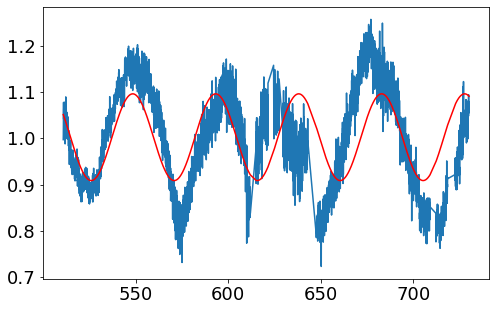

In [9]:
def fit_sin(x, w, phi, A, B):
    return A * np.sin(w * x - phi) + B
fit_sin_model = lmfit.Model(fit_sin)

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('phi', value=2, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results = fit_sin_model.fit(fit_ratio, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results)

plt.plot(cavity_freqs_filtered, fit_ratio)
plt.plot(cavity_freqs_filtered, fit_sin_model.eval(ratio_results.params, x=cavity_freqs_filtered), 'r')

### Fit bounced sinusoidal to fitted cavity ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 78
    # data points      = 5487
    # variables        = 5
    chi-square         = 21.9842758
    reduced chi-square = 0.00401027
    Akaike info crit   = -30277.1946
    Bayesian info crit = -30244.1439
[[Variables]]
    w:     0.12044856 +/- 3.3876e-04 (0.28%) (init = 0.125)
    xref:  613.877368 +/- 0.08254029 (0.01%) (init = 620)
    phi:   4.6456e-08 +/- 0.01520771 (32735975.12%) (init = 3.1)
    A:     0.12426511 +/- 0.00119117 (0.96%) (init = 0.2)
    B:     0.99403107 +/- 8.6256e-04 (0.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.867


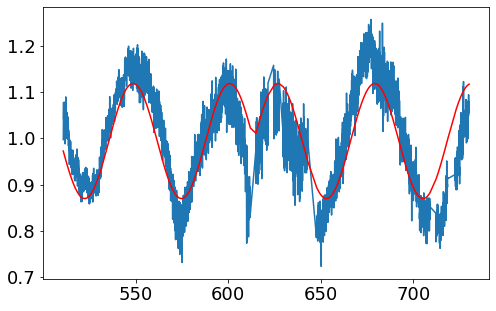

In [10]:
def fit_bounce_sin(x, w, xref, phi, A, B):
    return A * np.sin(w * np.abs(x - xref) - phi) + B
fit_bounce_sin_model = lmfit.Model(fit_bounce_sin)

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('xref', value=620, min=610, max=630),
    Parameter('phi', value=3.1, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results = fit_bounce_sin_model.fit(fit_ratio, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results)

plt.plot(cavity_freqs_filtered, fit_ratio)
plt.plot(cavity_freqs_filtered, fit_bounce_sin_model.eval(ratio_results.params, x=cavity_freqs_filtered), 'r')

## "Fit" cavity function using previously-fit kappas

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 5487
    # variables        = 2
    chi-square         = 1.5294e+11
    reduced chi-square = 27883873.4
    Akaike info crit   = 94068.7082
    Bayesian info crit = 94081.9285
[[Variables]]
    w_c:    649.330521 +/- 0.43385737 (0.07%) (init = 650)
    k_in:   126.3889 (fixed)
    k_tot:  164.0927 (fixed)
    A:      93257.1057 +/- 222.505414 (0.24%) (init = 40000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_c, A) = -0.604


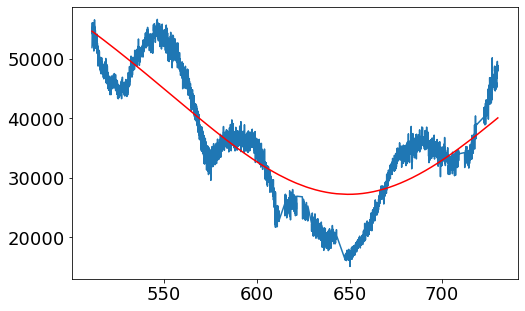

In [11]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=650, min=600, max=700),
    Parameter('k_in', value=126.3889, vary=False),
    Parameter('k_tot', value=164.092706, vary=False),
    Parameter('A', value=40000, min=0, max=100000),
    Parameter('B', value=0, vary=False),
)
#     k_in:   124.675367 +/- 2221517.43 (1781841.49%) (init = 100)
#     k_tot:  159.399874 +/- 9.07243447 (5.69%) (init = 100)
#     -------------------------------------------------------------
#     k_in:   37.7011050 +/- 9753600.40 (25870860.84%) (init = 100)
#     k_tot:  164.092706 +/- 4.54734643 (2.77%) (init = 100)

results_oldk = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered)
lmfit.report_fit(results_oldk)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs_filtered, cavity_ref_model.eval(results_oldk.params, w=cavity_freqs_filtered), 'r')

fit_ratio_oldk = cavity_intensity_filtered / (cavity_intensity_filtered + results_oldk.residual)

### Fit sunusoidal to cavity fit ratio

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 5487
    # variables        = 4
    chi-square         = 119.990563
    reduced chi-square = 0.02188411
    Akaike info crit   = -20967.2857
    Bayesian info crit = -20940.8451
[[Variables]]
    w:    0.12962756 +/- 7.1638e-04 (0.55%) (init = 0.125)
    phi:  6.27999998 +/- 0.05788856 (0.92%) (init = 2)
    A:    0.06489954 +/- 0.00286253 (4.41%) (init = 0.2)
    B:    0.98338616 +/- 0.00201791 (0.21%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(w, phi) = -0.995
    C(A, B)   =  0.115
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 145
    # data points      = 5487
    # variables        = 5
    chi-square         = 98.1981938
    reduced chi-square = 0.01791284
    Akaike info crit   = -22065.0192
    Bayesian info crit = -22031.9685
[[Variables]]
    w:     0.12168950 +/- 8.2652e-04 (0.68%) (init = 0.125)
    xref:  613.776

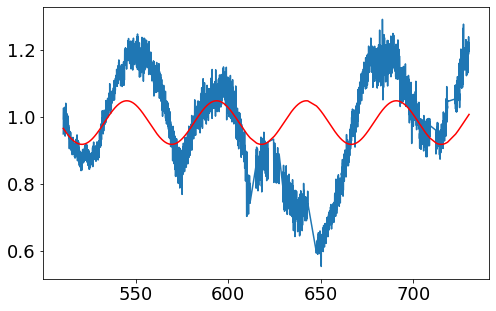

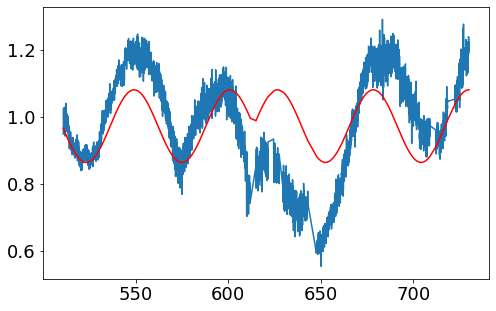

In [12]:
params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('phi', value=2, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results_oldk = fit_sin_model.fit(fit_ratio_oldk, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results_oldk)

plt.plot(cavity_freqs_filtered, fit_ratio_oldk)
plt.plot(cavity_freqs_filtered, fit_sin_model.eval(ratio_results_oldk.params, x=cavity_freqs_filtered), 'r')

################################

params_ratio = Parameters()
params_ratio.add_many(
    Parameter('w', value=0.125, min=0.08, max=0.18),
    Parameter('xref', value=620, min=610, max=630),
    Parameter('phi', value=3.1, min=0, max=6.28),
    Parameter('A', value=0.2, min=0, max=0.5),
    Parameter('B', value=1, min=0, max=2),
)
ratio_results_oldk = fit_bounce_sin_model.fit(fit_ratio_oldk, params_ratio, x=cavity_freqs_filtered)
lmfit.report_fit(ratio_results_oldk)

plt.figure()
plt.plot(cavity_freqs_filtered, fit_ratio_oldk)
plt.plot(cavity_freqs_filtered, fit_bounce_sin_model.eval(ratio_results_oldk.params, x=cavity_freqs_filtered), 'r')

# ----------------------------------------------------------
# Fit SiV Spectrum

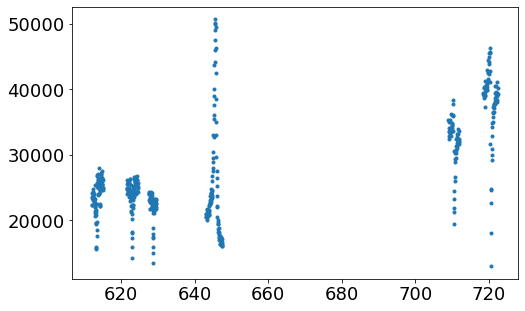

In [13]:
# Plot the regions that were excluded from the cavity fit
siv_indices = in_range(cavity_freqs, filter_range)
cavity_freqs_siv = cavity_freqs[siv_indices]
cavity_intensity_siv = cavity_intensity[siv_indices]

plt.plot(cavity_freqs_siv, cavity_intensity_siv, '.')

## Fitting SiV index 4

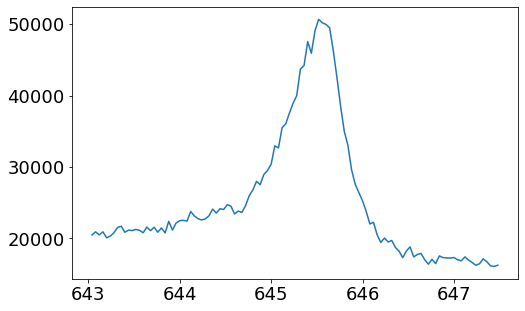

In [14]:
start, end = filter_range[3]
cavity_freqs_siv_4 = cavity_freqs_siv[(cavity_freqs_siv > start) & (cavity_freqs_siv < end)]
cavity_intensity_siv_4 =cavity_intensity_siv[(cavity_freqs_siv > start) & (cavity_freqs_siv < end)]

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)

### Fix gamma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 478
    # data points      = 112
    # variables        = 6
    chi-square         = 53893667.4
    reduced chi-square = 508430.824
    Akaike info crit   = 1477.41076
    Bayesian info crit = 1493.72176
[[Variables]]
    w_up:      645.592227 +/- 0.00516979 (0.00%) (init = 645.5)
    g_up:      8.24390883 +/- 6.02107955 (73.04%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       623.288199 +/- 31.9144513 (5.12%) (init = 642)
    k_in:      199.999975 +/- 175.879596 (87.94%) (init = 100)
    k_tot:     296.067035 +/- 432.807453 (146.19%) (init = 150)
    A:         143788.126 +/- 3130.38373 (2.18%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  1.000
    C(g_up, k_in)  =  1.000
    C(g_up, k_tot) =  1.000
    C(w_c, k_in)   = -1.000
    C(g_up, w_c)   = -1.000
    C(w_c, k_tot)  = -1.000
    C(w_up, g_up)  = -0.605
    C(w_up, k_in)  = -0

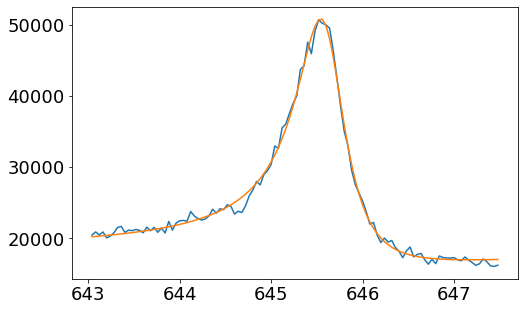

In [15]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=642, min=0, max=1000),
    Parameter('k_in', value=100, min=0, max=200),
    Parameter('k_tot', value=150, min=0, max=300),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = single_siv_ref_model.fit(cavity_intensity_siv_4, params, w=cavity_freqs_siv_4)
lmfit.report_fit(results)

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)
plt.plot(cavity_freqs_siv_4, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_4))

### Fix total kappa

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 195
    # data points      = 112
    # variables        = 6
    chi-square         = 54383761.4
    reduced chi-square = 513054.353
    Akaike info crit   = 1478.42466
    Bayesian info crit = 1494.73565
[[Variables]]
    w_up:      645.543376 +/- 0.29002432 (0.04%) (init = 645.5)
    g_up:      7.37607530 +/- 4.35246781 (59.01%) (init = 5.6)
    gamma_up:  8.7644e-08 +/- 0.30036577 (342712892.66%) (init = 0.1)
    w_c:       613.290002 +/- 109.104506 (17.79%) (init = 715)
    k_in:      125.819624 +/- 58.9418391 (46.85%) (init = 130)
    k_tot:     159.38 (fixed)
    A:         50827.7890 +/- 141187.378 (277.78%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma_up, A)    =  1.000
    C(k_in, A)        = -1.000
    C(gamma_up, k_in) = -1.000
    C(w_c, A)         =  1.000
    C(gamma_up, w_c)  =  1.000
    C(w_c, k_in)      = -1.000
    C(w_up, A)       

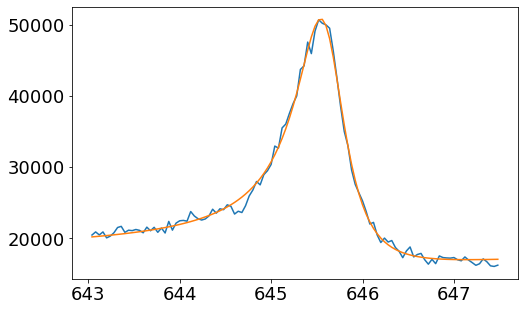

In [25]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, min=0, max=5),
    Parameter('w_c', value=715, min=0, max=1000),
    Parameter('k_in', value=130, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)

results = single_siv_ref_model.fit(cavity_intensity_siv_4, params, w=cavity_freqs_siv_4)
lmfit.report_fit(results)

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)
plt.plot(cavity_freqs_siv_4, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_4))

### Fix total kappa, gamma

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 101
    # data points      = 112
    # variables        = 5
    chi-square         = 55587714.9
    reduced chi-square = 519511.354
    Akaike info crit   = 1478.87708
    Bayesian info crit = 1492.46957
[[Variables]]
    w_up:      645.593888 +/- 0.00421291 (0.00%) (init = 645.5)
    g_up:      6.05292700 +/- 0.06688132 (1.10%) (init = 5.6)
    gamma_up:  0.1 (fixed)
    w_c:       633.376966 +/- 0.36753855 (0.06%) (init = 610)
    k_in:      107.798740 +/- 0.26470370 (0.25%) (init = 130)
    k_tot:     159.38 (fixed)
    A:         143672.421 +/- 3148.51478 (2.19%) (init = 6000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up, A)    = -0.985
    C(k_in, A)    = -0.961
    C(g_up, k_in) =  0.940
    C(w_up, w_c)  = -0.593
    C(w_c, A)     =  0.439
    C(g_up, w_c)  = -0.379
    C(w_c, k_in)  = -0.359
    C(w_up, g_up) = -0.191
    C(w_up, k_in) = -0.140
    C(w_up, 

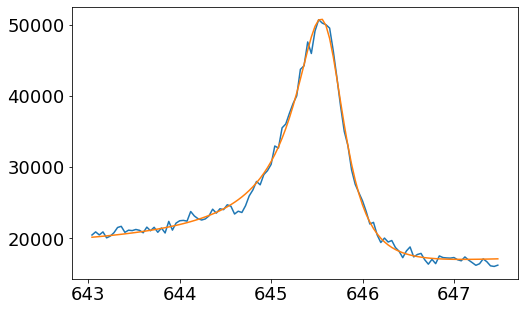

In [26]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=645.5, min=645, max=646),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.1, vary=False),
    Parameter('w_c', value=610, min=0, max=1000),
    Parameter('k_in', value=130, min=0, max=200),
    Parameter('k_tot', value=159.38, vary=False),
    Parameter('A', value=6000, min=5000, max=900000),
    Parameter('B', value=0, vary=False),
)
results = single_siv_ref_model.fit(cavity_intensity_siv_4, params, w=cavity_freqs_siv_4)
lmfit.report_fit(results)

plt.plot(cavity_freqs_siv_4, cavity_intensity_siv_4)
plt.plot(cavity_freqs_siv_4, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_4))

## Attempt at MCMC

In [29]:
emcee_kws = dict(steps=50*20, burn=300, thin=20, is_weighted=False)
emcee_params = results.params.copy()
emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

results_emcee = single_siv_ref_model.fit(cavity_intensity_siv_4, emcee_params, w=cavity_freqs_siv_4, method='emcee',
                         nan_policy='omit', fit_kws=emcee_kws)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.39it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 38.4647  65.3534  54.6811  66.3451  65.9416 125.7277]


[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 112
    # variables        = 6
    chi-square         = 13896986.9
    reduced chi-square = 131103.650
    Akaike info crit   = 1325.61258
    Bayesian info crit = 1341.92357
[[Variables]]
    w_up:       645.593870 +/- 0.00121690 (0.00%) (init = 645.5939)
    g_up:       6.05312022 +/- 0.00579158 (0.10%) (init = 6.052927)
    gamma_up:   0.1 (fixed)
    w_c:        633.377147 +/- 0.05245601 (0.01%) (init = 633.377)
    k_in:       107.799460 +/- 0.05722284 (0.05%) (init = 107.7987)
    k_tot:      159.38 (fixed)
    A:          143665.942 +/- 222.861406 (0.16%) (init = 143672.4)
    B:          0 (fixed)
    __lnsigma:  0.69314535 +/- 0.02899005 (4.18%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up, A)         = -0.994
    C(k_in, A)         = -0.993
    C(g_up, k_in)      =  0.991
    C(w_c, A)          =  0.967
    C(g_up, w_c)       = -0.

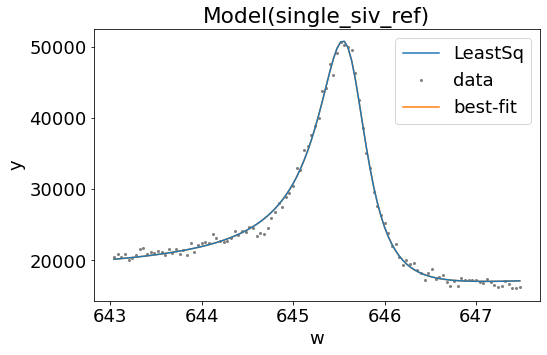

In [32]:
lmfit.report_fit(results_emcee)

ax = plt.plot(cavity_freqs_siv_4, single_siv_ref_model.eval(results.params, w=cavity_freqs_siv_4), label='LeastSq', zorder=100)
results_emcee.plot_fit(ax=ax, data_kws=dict(color='gray', markersize=2))
plt.show()

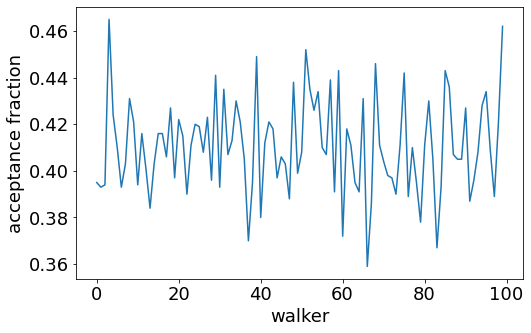

In [34]:
plt.plot(results_emcee.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

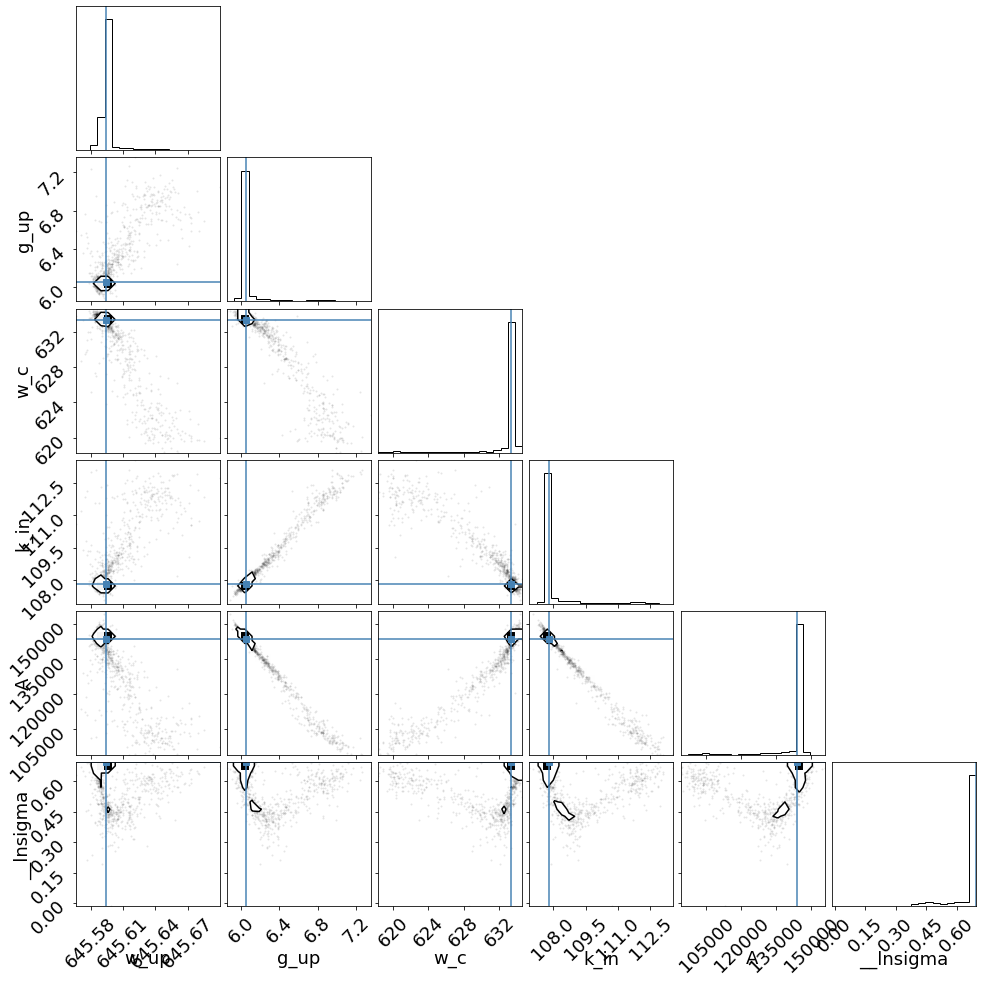

In [40]:
emcee_corner = corner.corner(results_emcee.flatchain, labels=results_emcee.var_names,
#                              truths=list(results_emcee.params.valuesdict().values()))
                             truths=np.array(list(results_emcee.params.valuesdict().values()))[[0, 1, 3, 4, 6, 8]]) # Remove params that are not varying

In [56]:
print("\nMedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(results_emcee.params)

# find the maximum likelihood solution
highest_prob = np.argmax(results_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, results_emcee.lnprob.shape)
mle_soln = results_emcee.chain[hp_loc]

print("\nMaximum likelihood Estimation")
print('-----------------------------')
idx = 0
for param in emcee_params:
    if not emcee_params[param].vary: continue
    print(param + ': ' + str(mle_soln[idx]))
    idx += 1


Median of posterior probability distribution
--------------------------------------------
[[Variables]]
    w_up:       645.593870 +/- 0.00121690 (0.00%) (init = 645.5939)
    g_up:       6.05312022 +/- 0.00579158 (0.10%) (init = 6.052927)
    gamma_up:   0.1 (fixed)
    w_c:        633.377147 +/- 0.05245601 (0.01%) (init = 633.377)
    k_in:       107.799460 +/- 0.05722284 (0.05%) (init = 107.7987)
    k_tot:      159.38 (fixed)
    A:          143665.942 +/- 222.861406 (0.16%) (init = 143672.4)
    B:          0 (fixed)
    __lnsigma:  0.69314535 +/- 0.02899005 (4.18%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up, A)         = -0.994
    C(k_in, A)         = -0.993
    C(g_up, k_in)      =  0.991
    C(w_c, A)          =  0.967
    C(g_up, w_c)       = -0.955
    C(w_c, k_in)       = -0.945
    C(w_up, w_c)       = -0.910
    C(w_up, A)         = -0.843
    C(w_up, g_up)      =  0.818
    C(w_up, k_in)      =  0.807
    C(k_in, __lnsigma) = -0

# Bulk SiV Fitting

In [59]:
def bulk_fit_siv(params, plot_fits=True):
    
    if plot_fits:
        plt.figure(figsize=[24, 20])   

    fit_params = defaultdict(list)
    fit_params_errors = defaultdict(list)
    reduced_chi = []

    for idx, file in enumerate(siv_files):
        # Get the SiV Data
        siv_data = np.loadtxt(siv_path + file)
        if len(siv_data.shape) == 1: siv_data = siv_data.reshape(1, len(siv_data))
        siv_mean = np.sum(siv_data, axis=0) / len(siv_data)

        # Extract SiV frequency axis
        siv_data_avg = np.loadtxt(siv_path.replace("scans", "avg") + file)
        siv_freqs = 1000 * (siv_data_avg[0] - 406)

        # Perform fit
        results = single_siv_ref_model.fit(siv_mean, params, w=siv_freqs)

        # Store fit results
        for param, param_results in results.params.items():
            if not param_results.vary: continue
            fit_params[param].append(param_results.value)
            fit_params_errors[param].append(param_results.stderr)
        reduced_chi.append(results.redchi)
        
        if plot_fits:
            plt.subplot(4, 3, idx+1)
            plt.plot(siv_freqs, siv_mean)
            plt.plot(siv_freqs, siv_mean + results.residual)
        
    # Plot fit results
    plt.figure(figsize=[32, 10])   
    for idx, (param, param_fit) in enumerate(fit_params.items()):
        plt.subplot(2, 4, idx+1)
        x_axis = range(len(param_fit))
        errors = [err if err is not None else 0 for err in fit_params_errors[param]]
        plt.bar(x_axis, param_fit, yerr=errors)
        plt.title(param)
        plt.gca().relim() # Ignore error bar scales

    plt.subplot(2, 4, idx+2)
    plt.bar(range(len(reduced_chi)), reduced_chi)
    plt.title("Reduced $\chi^2$")
    
    return fit_params, fit_params_errors, reduced_chi

In [60]:
# params = Parameters()
# params.add_many(
#     Parameter('w_up', value=645, min=644, max=646),
#     Parameter('g_up', value=5.6, min=1, max=20),
#     Parameter('gamma_up', value=0.1, min=0, max=5),
#     Parameter('w_c', value=715, min=0, max=1000),
#     Parameter('k_in', value=100, min=0, max=200),
#     Parameter('k_tot', value=159.38, vary=False),
#     Parameter('A', value=6000, min=5000, max=900000),
#     Parameter('B', value=0.1, min=0, max=1000),
# )
# fit_params, fit_params_errors, reduced_chi = bulk_fit_siv(params)

OSError: ../data/2021_03_03_stitched/10_17_58.txt not found.

<Figure size 1728x1440 with 0 Axes>